### MACHINE TRANSLATION MODEL

In this project, I'm applying what I learnt from DataCamp on Machine Translation from English to French.<br>
Thank you to DataCamp, especially to Thushan Ganegedara, Mona Khalil, Ruanne Van Der Walt for this session.

Here is the work pipeline:
1. Read data from txt files and split into train and test dataframe
2. Tokenize sentences and transform to one hot encode sequence data
3. Build model
4. Predict on test data/ Translate English sentences in test data
5. Evaluate the model using BLEU score (future work)

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10.0, 5.0)
%matplotlib inline

### 1. Read data from txt file

In [2]:
en_sents = list()
with open('vocab_en.txt', encoding='utf-8') as txt_file:
    for line in txt_file:
        new_line = line.rstrip('\n')
        en_sents.append(new_line)

fr_sents = list()
with open('vocab_fr.txt', encoding='utf-8') as txt_file:
    for line in txt_file.readlines():
        new_line = line.rstrip('\n')
        fr_sents.append(new_line)
        
df = pd.DataFrame({'english_sentence':en_sents, 'french_sentence': fr_sents})
df.head()

,english_sentence,french_sentence
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
2,"california is usually quiet during march , and...","california est généralement calme en mars , et..."
3,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et..."
4,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137860 entries, 0 to 137859
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   english_sentence  137860 non-null  object
 1   french_sentence   137860 non-null  object
dtypes: object(2)
memory usage: 2.1+ MB


In [4]:
#shuffle indicies to shuffle the rows
indicies = np.array(df.index)
np.random.shuffle(indicies)
indicies

array([ 35467,  43795, 115519, ..., 131125, 113297,  45122], dtype=int64)

#### Split data into train and test dataframe after shuffling row

In [5]:
train_size, test_size = int((137860/10) * 8), int((137860/10) * 2)

train_indicies, test_indicies = indicies[:train_size], indicies[train_size:]

train_df = df.iloc[train_indicies, :]
test_df = df.iloc[test_indicies, :]

In [7]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Conv1D, Dense, Flatten, Input, MaxPooling1D, GRU, RepeatVector, \
                        Dropout, BatchNormalization, TimeDistributed, LSTM, Dropout
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

### 2. Tokenize sentences then transform to one hot encode sequence data

In [8]:
en_token = Tokenizer(oov_token='unknown')
en_token.fit_on_texts(train_df['english_sentence'])

fr_token = Tokenizer(oov_token='unknown')
fr_token.fit_on_texts(train_df['french_sentence'])

In [9]:
en_index_to_word = en_token.index_word
fr_index_to_word = fr_token.index_word

en_word_to_index = en_token.word_index
fr_word_to_index = fr_token.word_index

In [10]:
max_en_len = max([len(i) for i in en_token.texts_to_sequences(train_df['english_sentence'])])
max_fr_len = max([len(i) for i in fr_token.texts_to_sequences(train_df['french_sentence'])])
print(max_en_len, max_fr_len)

15 21


In [11]:
en_vocab = len(en_token.index_word) + 1
fr_vocab = len(fr_token.index_word) + 1
print(en_vocab, fr_vocab)

201 345


In [12]:
en_oh = to_categorical(np.arange(0,en_vocab))
fr_oh = to_categorical(np.arange(0, fr_vocab))
print(en_oh.shape, fr_oh.shape)

(201, 201) (345, 345)


In [13]:
#function word to oh
def word2oh(word, language='en'):
    oh = ''
    if language == 'en':
        index = en_word_to_index[word]
        oh = en_oh[index]
    elif language =='fr':
        index = fr_word_to_index[word]
        oh = fr_oh[index]      
    return oh

In [14]:
#function sentence to one hot, there is reverse argument to reverse one hot encode of english for better model performance
def sent2oh(sentence, language='en', reverse=False):
    oh = list()
    if language=='en':
        sequence = en_token.texts_to_sequences([sentence])
        sequence = pad_sequences(sequence, padding='post', maxlen=max_en_len) #add padding
        if reverse == True:
            sequence = sequence[:, ::-1]
        for seq in sequence:
            oh.append(en_oh[seq])
    elif language == 'fr':
        sequence = fr_token.texts_to_sequences([sentence])
        sequence = pad_sequences(sequence, padding='post', maxlen=max_fr_len)
        if reverse == True:
            sequence = sequence[:, ::-1]
        for seq in sequence:
            oh.append(fr_oh[seq])     
    return np.array(oh)

In [15]:
train_en_oh_rev = np.vstack([(sent2oh(sent, reverse=True)) for sent in train_df['english_sentence']])
train_fr_oh = np.vstack([(sent2oh(sent, language='fr')) for sent in train_df['french_sentence']])

print(train_en_oh_rev.shape, train_fr_oh.shape)

(110288, 15, 201) (110288, 21, 345)


In [16]:
test_en_oh_rev = np.vstack([(sent2oh(sent, reverse=True)) for sent in test_df['english_sentence']])
test_fr_oh = np.vstack([(sent2oh(sent, language='fr')) for sent in test_df['french_sentence']])

print(test_en_oh_rev.shape, test_fr_oh.shape)

(27572, 15, 201) (27572, 21, 345)


### 3. Build model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 201)]    0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 201), (None, 243009      input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 21, 201)      0           gru[0][1]                        
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 21, 201)      243009      repeat_vector[0][0]              
             

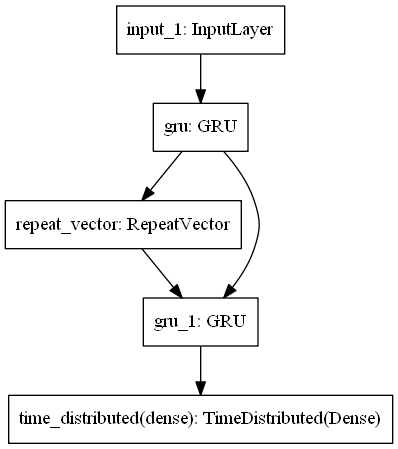

In [17]:
hsize = en_vocab

#encoder
en_input = Input(shape=(max_en_len, en_vocab))
en_gru = GRU(hsize, return_state=True)
en_out, en_state = en_gru(en_input)

#decoder
de_input = RepeatVector(max_fr_len)(en_state)
de_gru = GRU(hsize, return_sequences=True)
de_out = de_gru(de_input, initial_state=en_state)

#prediction layer
de_dense_time = TimeDistributed(Dense(fr_vocab, activation='softmax'))
de_pred = de_dense_time(de_out)

#compiling the model
nmt = Model(inputs=en_input, outputs=de_pred)

#summarize model
nmt.summary()

#plot graph
plot_model(nmt, to_file='layout.png')

In [18]:
nmt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
nmt.fit(train_en_oh_rev, train_fr_oh, batch_size=128, epochs=10, validation_split=0.2, callbacks=[early_stopping])

Train on 88230 samples, validate on 22058 samples
Epoch 1/10
88230/88230 [==============================] - 154s 2ms/sample - loss: 1.7918 - acc: 0.5807 - val_loss: 1.1926 - val_acc: 0.6779
Epoch 2/10
88230/88230 [==============================] - 160s 2ms/sample - loss: 0.9967 - acc: 0.7160 - val_loss: 0.8636 - val_acc: 0.7467
Epoch 3/10
88230/88230 [==============================] - 163s 2ms/sample - loss: 0.7862 - acc: 0.7662 - val_loss: 0.6958 - val_acc: 0.7913
Epoch 4/10
88230/88230 [==============================] - 153s 2ms/sample - loss: 0.6440 - acc: 0.8060 - val_loss: 0.5775 - val_acc: 0.8243
Epoch 5/10
88230/88230 [==============================] - 160s 2ms/sample - loss: 0.5253 - acc: 0.8401 - val_loss: 0.4744 - val_acc: 0.8571
Epoch 6/10
88230/88230 [==============================] - 153s 2ms/sample - loss: 0.4336 - acc: 0.8694 - val_loss: 0.4213 - val_acc: 0.8756
Epoch 7/10
88230/88230 [==============================] - 156s 2ms/sample - loss: 0.3552 - acc: 0.8954 - val_l

### 4. Predict on test data or translate English sentences in test data into French

In [19]:
pred_fr_oh = nmt.predict(test_en_oh_rev)
pred_fr_oh.shape

(27572, 21, 345)

In [20]:
#function to transform one hots to french sentences
def oh2fr(ohs):
    sequences = np.argmax(ohs, axis=-1)
    sentences = list()
    for seq in sequences:
        sent = [fr_index_to_word[i] for i in seq if i != 0]
        sent = ' '.join(sent)
        sentences.append(sent)
    return sentences

In [21]:
pred_fr = oh2fr(pred_fr_oh)

#### Compare 10 predictions with Frech sentences

In [22]:
for i in range(10):
    print('Predict: ', pred_fr[i])
    print('True: ', test_df['french_sentence'].iloc[i])
    print('==========')


Predict:  la france est parfois froid en l' de l' automne est parfois est en mai
True:  la france est parfois froid en automne , mais il est parfois agréable en mai .
Predict:  les états unis est généralement chaud au mois de mars mais il est merveilleux en juillet
True:  les états-unis est généralement chaud au mois de mars , mais il est merveilleux en juin .
Predict:  elle n'aime les oranges les raisins et les pommes
True:  elle n'aime les oranges , les raisins et les pommes .
Predict:  la france est parfois occupée en novembre mais il est agréable en mai
True:  la france est parfois occupée en novembre , mais il est agréable en mai .
Predict:  l' inde est généralement froid en juin et il gèle en hiver
True:  l' inde est généralement froid en juin , et il gèle en mai .
Predict:  leur fruit préféré est la banane mais votre favori est la pomme
True:  leur fruit préféré est la banane , mais votre favori est la pomme .
Predict:  les états unis est beau en juin mais il est généralement ag

### 5. Evaluate model using BLEU score (future work)